# In this notebook i will be creating an Multi layer perceptron from scratch using Numpy and use that to make predictions on Forest Fire Dataset

In [1]:
# --- Cell 1: Class and Function Definitions ---

import numpy as np
import os
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

class MLP:
    """A Multi-Layer Perceptron for binary classification."""
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]) * np.sqrt(1. / sizes[i-1]))
            self.biases.append(np.zeros((sizes[i], 1)))

    def forward(self, X):
        """Performs the forward pass through the network."""
        self.activations = [X]
        self.z = []
        for i in range(self.num_layers):
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            if i < self.num_layers - 1:
                a = self.relu(z)
            else:
                a = self.sigmoid(z)
            self.activations.append(a)
        return self.activations[-1]

    def backward(self, X, y):
        """Performs the backward pass to calculate gradients."""
        m = X.shape[1]
        gradients = []
        dZ = self.activations[-1] - y
        
        for i in range(self.num_layers - 1, -1, -1):
            dW = (1 / m) * np.dot(dZ, self.activations[i].T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            gradients.append((dW, db))
            
            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)
                dZ = dA * self.gradient_relu(self.z[i-1])
                
        return gradients[::-1]

    def update_parameters(self, gradients, learning_rate):
        """Updates weights and biases using calculated gradients."""
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]

    def relu(self, Z):
        """ReLU activation function."""
        return np.maximum(0, Z)

    def gradient_relu(self, Z):
        """Gradient of the ReLU function."""
        return (Z > 0).astype(int)

    def sigmoid(self, Z):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-Z))

class DataLoader:
    """A simple data loader to iterate through data in batches."""
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = len(X)
        self.indices = np.arange(self.num_samples)
        self.num_batches = self.num_samples // self.batch_size
    
    def __iter__(self):
        np.random.shuffle(self.indices)
        for i in range(self.num_batches):
            batch_indices = self.indices[i * self.batch_size:(i + 1) * self.batch_size]
            yield self.X[batch_indices], self.y[batch_indices]

    def __len__(self):
        return self.num_batches

def load_image_data(data_dir, image_size=(64, 64)):
    """Loads, preprocesses, and shuffles image data from a directory."""
    images = []
    labels = []
    processed_count = 0
    skipped_count = 0
    
    for label, class_name in enumerate(['Non_Fire', 'Fire']):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Directory not found: {class_dir}")
            continue
        
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            
            if not os.path.isfile(img_path) or os.path.getsize(img_path) == 0:
                print(f"Skipping non-file or empty file: {filename}")
                skipped_count += 1
                continue
            
            try:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                images.append(np.array(img))
                labels.append(label)
                processed_count += 1
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
                skipped_count += 1

    if not images:
        print("No images were loaded. Please check your data paths and files.")
        return np.array([]), np.array([]), processed_count, skipped_count
        
    images = np.array(images)
    labels = np.array(labels).reshape(-1, 1)

    num_samples = images.shape[0]
    images_flattened = images.reshape(num_samples, -1) / 255.0
    images_shuffled, labels_shuffled = shuffle(images_flattened, labels, random_state=42)
    
    return images_shuffled, labels_shuffled, processed_count, skipped_count

def print_model_summary(mlp_model):
    """Prints a summary of the MLP model's architecture."""
    print("-------------------- Model Summary --------------------")
    print(f"Input Layer: {mlp_model.input_size} neurons")
    
    current_size = mlp_model.input_size
    for i, hidden_size in enumerate(mlp_model.hidden_sizes):
        num_params = (current_size * hidden_size) + hidden_size
        print(f"Hidden Layer {i+1}: {hidden_size} neurons")
        print(f"  - Parameters: {num_params}")
        current_size = hidden_size
        
    output_size = mlp_model.output_size
    num_params = (current_size * output_size) + output_size
    print(f"Output Layer: {output_size} neuron")
    print(f"  - Parameters: {num_params}")
    
    total_params = sum(w.size + b.size for w, b in zip(mlp_model.weights, mlp_model.biases))
    print("-------------------------------------------------------")
    print(f"Total parameters: {total_params}")
    print("-------------------------------------------------------")

In [2]:
# --- Cell 2: Training Block ---
if __name__ == "__main__":
    train_path = '/kaggle/input/forest-fire-images/Data/Train_Data'
    test_path = '/kaggle/input/forest-fire-images/Data/Test_Data'
    
    print("Loading training data from:", train_path)
    X_train_val, y_train_val, train_processed, train_skipped = load_image_data(train_path)
    print(f"Train data summary: Processed {train_processed} files, Skipped {train_skipped} files.")
    
    print("\nLoading testing data from:", test_path)
    X_test, y_test, test_processed, test_skipped = load_image_data(test_path)
    print(f"Test data summary: Processed {test_processed} files, Skipped {test_skipped} files.")
    
    if X_train_val.size == 0 or X_test.size == 0:
        print("Cannot proceed. Training or testing data is empty.")
    else:
        # Split the training data (70% train, 10% validation)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.125, random_state=42, shuffle=True)
        
        print(f"\nTraining samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")

        input_size = X_train.shape[1]
        hidden_sizes = [64, 32] 
        output_size = 1
        mlp = MLP(input_size, hidden_sizes, output_size)

        num_epochs = 100
        learning_rate = 0.01
        batch_size = 32

        train_loader = DataLoader(X_train, y_train, batch_size)

        print("\nStarting training...")
        for epoch in range(num_epochs):
            for X_batch, y_batch in train_loader:
                outputs = mlp.forward(X_batch.T)
                gradients = mlp.backward(X_batch.T, y_batch.T)
                mlp.update_parameters(gradients, learning_rate)

            epsilon = 1e-8
            train_outputs = mlp.forward(X_train.T)
            train_loss = -np.mean(y_train.T * np.log(train_outputs + epsilon) + (1 - y_train.T) * np.log(1 - train_outputs + epsilon))
            train_predictions = (train_outputs >= 0.5).astype(int)
            train_accuracy = np.mean(train_predictions == y_train.T) * 100
            
            val_outputs = mlp.forward(X_val.T)
            val_loss = -np.mean(y_val.T * np.log(val_outputs + epsilon) + (1 - y_val.T) * np.log(1 - val_outputs + epsilon))
            val_predictions = (val_outputs >= 0.5).astype(int)
            val_accuracy = np.mean(val_predictions == y_val.T) * 100

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        print("\nTraining complete.")

Loading training data from: /kaggle/input/forest-fire-images/Data/Train_Data
Skipping non-file or empty file: F_861.jpg
Skipping non-file or empty file: F_604.jpg
Skipping non-file or empty file: F_673.jpg
Skipping non-file or empty file: F_818.jpg
Skipping non-file or empty file: F_84.jpg
Skipping non-file or empty file: F_844.jpg
Skipping non-file or empty file: F_732.jpg
Skipping non-file or empty file: F_753.jpg
Skipping non-file or empty file: F_61.jpg
Skipping non-file or empty file: F_925.jpg
Skipping non-file or empty file: F_614.jpg
Skipping non-file or empty file: F_595.jpg
Skipping non-file or empty file: F_715.jpg
Skipping non-file or empty file: F_609.jpg
Skipping non-file or empty file: F_806.jpg
Skipping non-file or empty file: F_736.jpg
Skipping non-file or empty file: F_789.jpg
Skipping non-file or empty file: F_936.jpg
Skipping non-file or empty file: F_607.jpg
Skipping non-file or empty file: F_621.jpg
Skipping non-file or empty file: F_933.jpg
Skipping non-file or e

In [3]:
# --- Cell 3: Save Model ---
# This block is executed after the training in Cell 2 is complete.
if 'mlp' in locals():
    print("Saving trained model to wildfire_mlp_model.npz...")
    
    # Create dictionaries to hold the weights and biases
    weights_and_biases = {f'w{i}': mlp.weights[i] for i in range(len(mlp.weights))}
    biases_only = {f'b{i}': mlp.biases[i] for i in range(len(mlp.biases))}
    
    # Combine both dictionaries into a single one
    all_params = {**weights_and_biases, **biases_only}
    
    # Save the dictionary to a compressed .npz file
    np.savez('wildfire_mlp_model.npz', **all_params)
    print("Model saved successfully.")

Saving trained model to wildfire_mlp_model.npz...
Model saved successfully.


In [4]:
# --- Cell 4: Load and Evaluate Model ---
# This block loads the saved model and evaluates it on the test and validation data.
if os.path.exists('wildfire_mlp_model.npz'):
    print("\nLoading model from file...")
    
    # Load the compressed data from the .npz file
    loaded_params = np.load('wildfire_mlp_model.npz', allow_pickle=True)
    
    # Reconstruct the weights and biases from the loaded data
    loaded_weights = [loaded_params[f'w{i}'] for i in range(len(mlp.weights))]
    loaded_biases = [loaded_params[f'b{i}'] for i in range(len(mlp.biases))]

    # Create a new MLP instance and assign the loaded parameters
    # The input and hidden layer sizes must be the same as the trained model
    loaded_mlp = MLP(input_size, hidden_sizes, output_size)
    loaded_mlp.weights = loaded_weights
    loaded_mlp.biases = loaded_biases
    
    print("Model loaded successfully. Evaluating on validation and test data.")
    
    # Evaluate on Validation Set
    epsilon = 1e-8
    val_outputs_loaded = loaded_mlp.forward(X_val.T)
    val_loss_loaded = -np.mean(y_val.T * np.log(val_outputs_loaded + epsilon) + (1 - y_val.T) * np.log(1 - val_outputs_loaded + epsilon))
    val_predictions_loaded = (val_outputs_loaded >= 0.5).astype(int)
    val_accuracy_loaded = np.mean(val_predictions_loaded == y_val.T) * 100
    
    print(f"\nFinal Validation Loss (from loaded model): {val_loss_loaded:.4f}")
    print(f"Final Validation Accuracy (from loaded model): {val_accuracy_loaded:.2f}%")
    
    # Evaluate on Test Set
    test_outputs_loaded = loaded_mlp.forward(X_test.T)
    test_loss_loaded = -np.mean(y_test.T * np.log(test_outputs_loaded + epsilon) + (1 - y_test.T) * np.log(1 - test_outputs_loaded + epsilon))
    test_predictions_loaded = (test_outputs_loaded >= 0.5).astype(int)
    test_accuracy_loaded = np.mean(test_predictions_loaded == y_test.T) * 100
    
    print(f"\nFinal Test Loss (from loaded model): {test_loss_loaded:.4f}")
    print(f"Final Test Accuracy (from loaded model): {test_accuracy_loaded:.2f}%")


Loading model from file...
Model loaded successfully. Evaluating on validation and test data.

Final Validation Loss (from loaded model): 0.1984
Final Validation Accuracy (from loaded model): 93.41%

Final Test Loss (from loaded model): 0.4666
Final Test Accuracy (from loaded model): 90.00%


In [5]:
# Print the model summary here
print_model_summary(loaded_mlp)

-------------------- Model Summary --------------------
Input Layer: 12288 neurons
Hidden Layer 1: 64 neurons
  - Parameters: 786496
Hidden Layer 2: 32 neurons
  - Parameters: 2080
Output Layer: 1 neuron
  - Parameters: 33
-------------------------------------------------------
Total parameters: 788609
-------------------------------------------------------


**Input Layer: 12,288 neurons**
This number represents the size of the data your model is taking in. For your image classification task, it's the total number of pixels in each image. Since you're using 64×64 pixel images with 3 color channels (RGB), the calculation is:

64×64×3=12,288

Each of these 12,288 neurons corresponds to a single pixel value in your flattened image data.

**Hidden Layers**
The hidden layers are the "brains" of your network, where the model performs calculations to find patterns in the data.

**Hidden Layer 1: 64 neurons**
This is the first hidden layer. It takes the 12,288 input values and transforms them into 64 new values. The number of parameters (the weights and biases that the model learns) for this layer is calculated as:
(12,288 inputs×64 neurons)+64 biases=786,432+64=786,496

**Hidden Layer 2: 32 neurons**
This is the second hidden layer. It takes the 64 values from the first hidden layer and condenses them into 32 values. The number of parameters is calculated as:
(64 inputs×32 neurons)+32 biases=2,048+32=2,080

**Output Layer: 1 neuron**
This is the final layer that produces the model's prediction. For your binary classification (fire or non-fire), you only need one neuron. The output of this neuron, after being passed through the sigmoid activation function, is a value between 0 and 1, which represents the probability that the image contains a fire. The number of parameters is:
(32 inputs×1 neuron)+1 bias=32+1=33

Total Parameters: 788,609

In [6]:
# --- Cell 4: Load and Evaluate Model ---
# This block loads the saved model and evaluates it on the new dataset.

import os



# This function is now more robust to different casing in folder names.
def load_image_data(data_dir, image_size=(64, 64)):
    """Loads, preprocesses, and shuffles image data from a directory."""
    images = []
    labels = []
    processed_count = 0
    skipped_count = 0
    
    # Check for both "Fire"/"Non_Fire" and "fire"/"nofire" folder names
    class_names = [['Non_Fire', 'Fire'], ['nofire', 'fire']]

    found_classes = False
    for label, class_pair in enumerate(class_names):
        non_fire_dir = os.path.join(data_dir, class_pair[0])
        fire_dir = os.path.join(data_dir, class_pair[1])
        
        if os.path.exists(non_fire_dir) and os.path.exists(fire_dir):
            found_classes = True
            
            for class_label, class_name in enumerate(class_pair):
                class_dir = os.path.join(data_dir, class_name)
                
                for filename in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, filename)
                    
                    if not os.path.isfile(img_path) or os.path.getsize(img_path) == 0:
                        skipped_count += 1
                        continue
                    
                    try:
                        img = Image.open(img_path).convert('RGB').resize(image_size)
                        images.append(np.array(img))
                        labels.append(class_label)
                        processed_count += 1
                    except Exception as e:
                        print(f"Error loading image {filename}: {e}")
                        skipped_count += 1
            break # Exit the loop once a valid pair of class folders is found

    if not found_classes:
        print("No 'Fire'/'Non_Fire' or 'fire'/'nofire' folders found in the specified path.")
        return np.array([]), np.array([]), processed_count, skipped_count

    if not images:
        print("No images were loaded. Please check your data paths and files.")
        return np.array([]), np.array([]), processed_count, skipped_count
        
    images = np.array(images)
    labels = np.array(labels).reshape(-1, 1)

    num_samples = images.shape[0]
    images_flattened = images.reshape(num_samples, -1) / 255.0
    images_shuffled, labels_shuffled = shuffle(images_flattened, labels, random_state=42)
    
    return images_shuffled, labels_shuffled, processed_count, skipped_count

if os.path.exists('wildfire_mlp_model.npz'):
    print("\nLoading model from file...")
    loaded_params = np.load('wildfire_mlp_model.npz', allow_pickle=True)
    
    # These values must be consistent with the trained model
    input_size = 64 * 64 * 3  # Based on image_size=(64, 64) and 3 color channels
    hidden_sizes = [64, 32] 
    output_size = 1

    loaded_weights = [loaded_params[f'w{i}'] for i in range(len(hidden_sizes) + 1)]
    loaded_biases = [loaded_params[f'b{i}'] for i in range(len(hidden_sizes) + 1)]

    loaded_mlp = MLP(input_size, hidden_sizes, output_size)
    loaded_mlp.weights = loaded_weights
    loaded_mlp.biases = loaded_biases
    
    print("Model loaded successfully.")
    
    # Corrected path to the training data within your new dataset
    new_data_path = '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training'
    
    print("\nLoading and evaluating new dataset from:", new_data_path)
    X_new, y_new, new_processed, new_skipped = load_image_data(new_data_path)

    if X_new.size > 0:
        print(f"New dataset summary: Processed {new_processed} files, Skipped {new_skipped} files.")
        
        # Use the loaded model to make predictions on the new data
        new_outputs = loaded_mlp.forward(X_new.T)
        
        # Calculate performance metrics
        epsilon = 1e-8
        new_loss = -np.mean(y_new.T * np.log(new_outputs + epsilon) + (1 - y_new.T) * np.log(1 - new_outputs + epsilon))
        new_predictions = (new_outputs >= 0.5).astype(int)
        new_accuracy = np.mean(new_predictions == y_new.T) * 100
        
        print(f"\nNew Dataset Loss: {new_loss:.4f}")
        print(f"New Dataset Accuracy: {new_accuracy:.2f}%")
    else:
        print("No data found in the new dataset path. Cannot evaluate.")


Loading model from file...
Model loaded successfully.

Loading and evaluating new dataset from: /kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training
New dataset summary: Processed 1520 files, Skipped 0 files.

New Dataset Loss: 0.1347
New Dataset Accuracy: 95.26%



Generating Confusion Matrix and Classification Report...


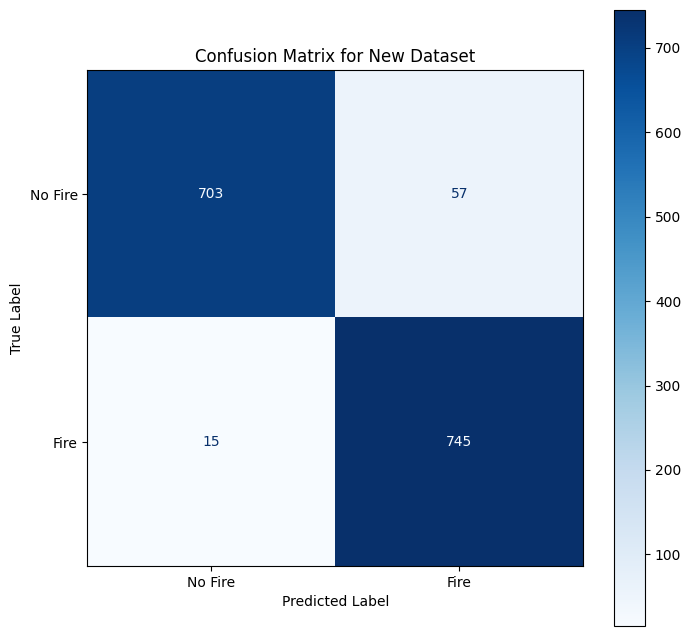


Classification Report:
              precision    recall  f1-score   support

     No Fire       0.98      0.93      0.95       760
        Fire       0.93      0.98      0.95       760

    accuracy                           0.95      1520
   macro avg       0.95      0.95      0.95      1520
weighted avg       0.95      0.95      0.95      1520



In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

if 'new_predictions' in locals() and 'y_new' in locals():
    print("\nGenerating Confusion Matrix and Classification Report...")
    
    # Generate and plot the confusion matrix
    cm = confusion_matrix(y_new, new_predictions.T)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title('Confusion Matrix for New Dataset')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_new, new_predictions.T, target_names=['No Fire', 'Fire']))

else:
    print("Predictions and true labels are not available. Please run the previous cell first.")



Calculating and Plotting Advanced Metrics...

Precision: 0.9289
Recall: 0.9803
F1-Score: 0.9539


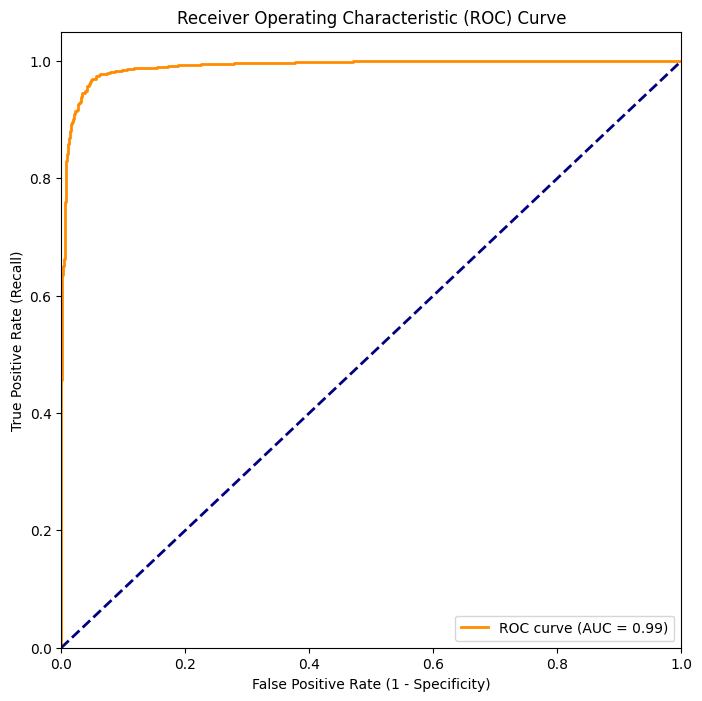

In [8]:
# --- Cell 6: Advanced Metrics and ROC Curve ---
# This block calculates and plots advanced performance metrics.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# Assuming 'new_predictions', 'new_outputs', and 'y_new' are available from Cell 4.
if 'new_predictions' in locals() and 'y_new' in locals() and 'new_outputs' in locals():
    print("\nCalculating and Plotting Advanced Metrics...")

    # Calculate Precision, Recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_new, new_predictions.T, average='binary')
    
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    
    # Calculate ROC curve and AUC
    # Note: `new_outputs` contains the probabilities, which are needed for ROC.
    fpr, tpr, thresholds = roc_curve(y_new.T.flatten(), new_outputs.T.flatten())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("Required data (predictions, outputs, and labels) not found. Please run previous cells first.")

Finding and displaying misclassified images...


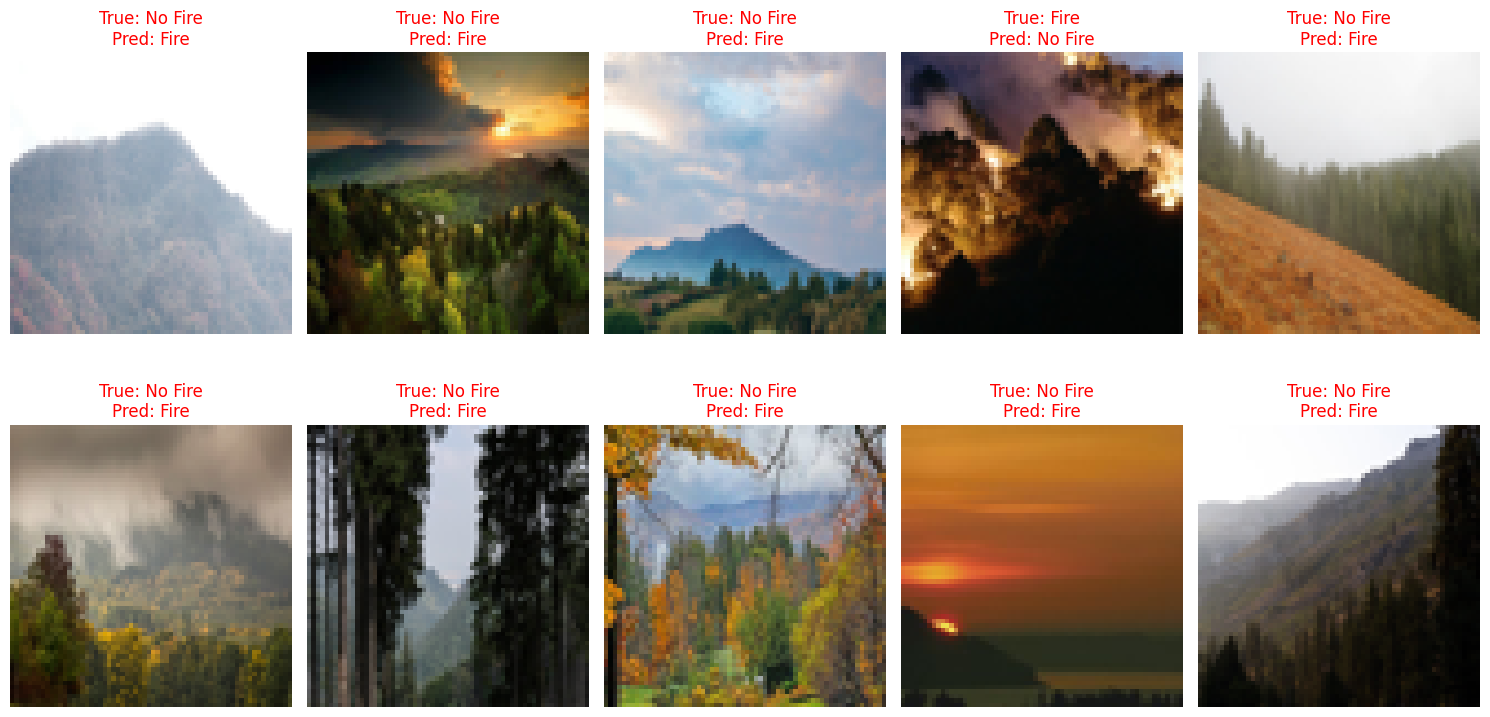

In [9]:
# --- Cell 6: Analyze Misclassified Images ---

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'new_predictions' and 'y_new' are available from Cell 4.
if 'new_predictions' in locals() and 'y_new' in locals():
    print("Finding and displaying misclassified images...")
    
    # Reshape predictions and labels to match
    y_true = y_new.flatten()
    y_pred = new_predictions.T.flatten()
    
    # Find indices where true labels do not match predicted labels
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    # Set the number of images to display
    num_to_display = 10
    display_indices = np.random.choice(misclassified_indices, min(num_to_display, len(misclassified_indices)), replace=False)
    
    # Reshape the flattened image data back to its original shape
    images_reshaped = X_new.reshape(-1, 64, 64, 3)
    
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(display_indices):
        plt.subplot(2, 5, i + 1)
        # Display the image, making sure to use the correct data type
        plt.imshow(images_reshaped[idx].astype('float32'))
        
        true_label = "Fire" if y_true[idx] == 1 else "No Fire"
        predicted_label = "Fire" if y_pred[idx] == 1 else "No Fire"
        
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

else:
    print("Predictions and true labels are not available. Please run the previous cell first.")

Visualizing the first layer weights...


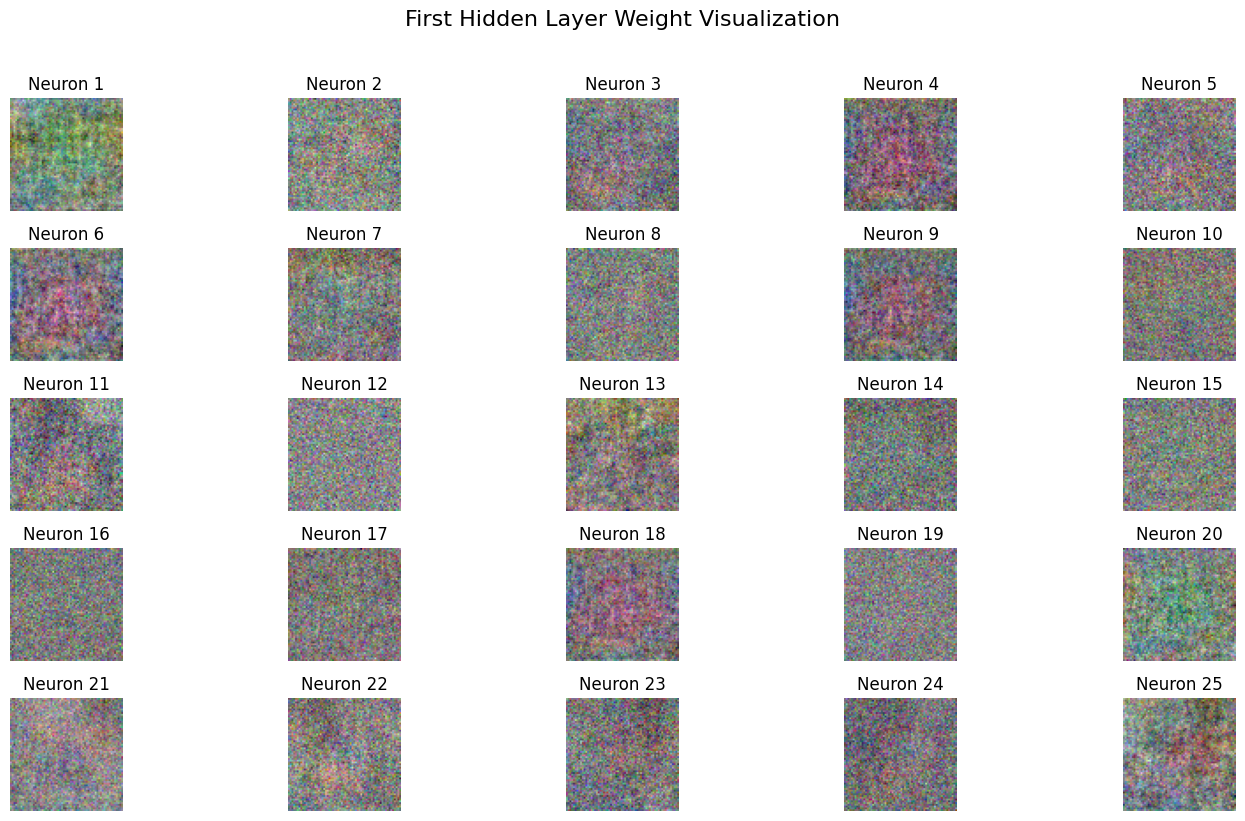

In [10]:
# --- Cell 7: Visualize First Layer Weights ---

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'loaded_mlp' is available from Cell 4.
if 'loaded_mlp' in locals():
    print("Visualizing the first layer weights...")
    
    # Get the weights of the first hidden layer
    weights = loaded_mlp.weights[0] # Shape (64, 12288)
    
    # Reshape the weights to the original image dimensions
    num_neurons = weights.shape[0]
    
    # Create a figure to display the weights
    plt.figure(figsize=(15, 8))
    for i in range(min(num_neurons, 25)): # Display up to 25 neurons
        plt.subplot(5, 5, i + 1)
        
        # Reshape the weights for a single neuron to a 64x64x3 image format
        # Normalize to 0-1 range for proper display
        neuron_weights = weights[i].reshape(64, 64, 3)
        neuron_weights = (neuron_weights - neuron_weights.min()) / (neuron_weights.max() - neuron_weights.min())
        
        plt.imshow(neuron_weights)
        plt.title(f"Neuron {i+1}")
        plt.axis('off')

    plt.suptitle('First Hidden Layer Weight Visualization', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

else:
    print("Model instance ('loaded_mlp') not found. Please run previous cells first.")

Making a prediction...


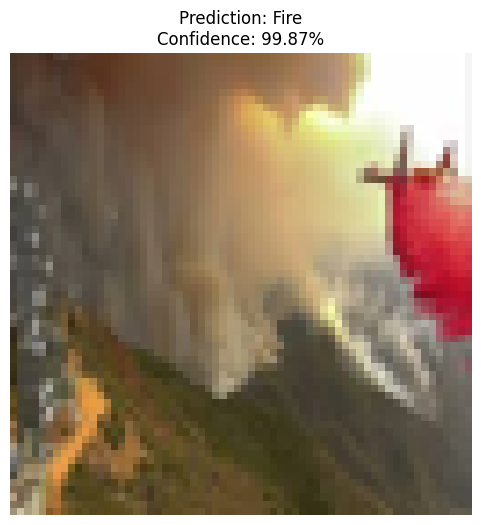

In [11]:
# --- Cell 8: Single Image Prediction from URL ---
import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming MLP and other necessary functions from previous cells are defined
# and the 'wildfire_mlp_model.npz' file exists.

def predict_single_image(url):
    """
    Downloads an image from a URL, preprocesses it, and makes a prediction
    using the loaded MLP model.

    Args:
        url (str): The URL of the image to predict.
    """
    try:
        # Step 1: Download the image from the URL
        print(f"Downloading image from URL: {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        image_data = BytesIO(response.content)
        img = Image.open(image_data).convert('RGB')
        
        # Step 2: Preprocess the image to match model's input
        img = img.resize((64, 64))
        
        # Convert to numpy array and normalize
        img_array = np.array(img, dtype=np.float32) / 255.0
        
        # Flatten the image to a single vector and reshape for the model
        # The model expects a column vector, so shape should be (pixel_count, 1)
        flat_image = img_array.reshape(-1, 1)

        # Step 3: Make a prediction
        print("Making a prediction...")
        prediction_output = loaded_mlp.forward(flat_image)
        prediction = (prediction_output >= 0.5).astype(int)
        
        # Determine the class based on the prediction
        predicted_class = "Fire" if prediction[0, 0] == 1 else "No Fire"
        confidence = prediction_output[0, 0] * 100
        
        # Step 4: Display the image and prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRGo-wL7U8URcoi_wmvJstix4sT_HGCsjc69g&s'
predict_single_image(image_url)

Making a prediction...


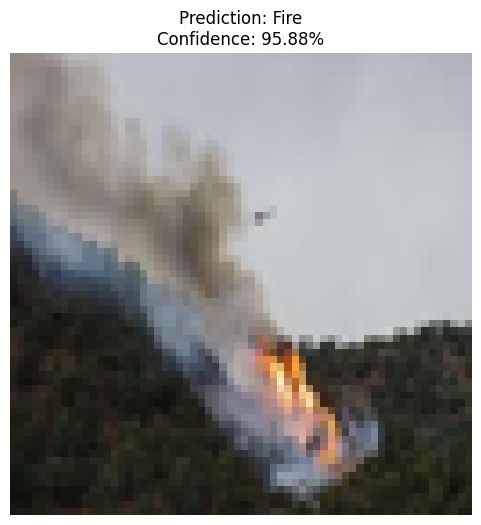

In [12]:
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7GEZ8xESszXqcqEL7Qs-zur0OSUzf5z6I4g&s'
predict_single_image(image_url)

Making a prediction...


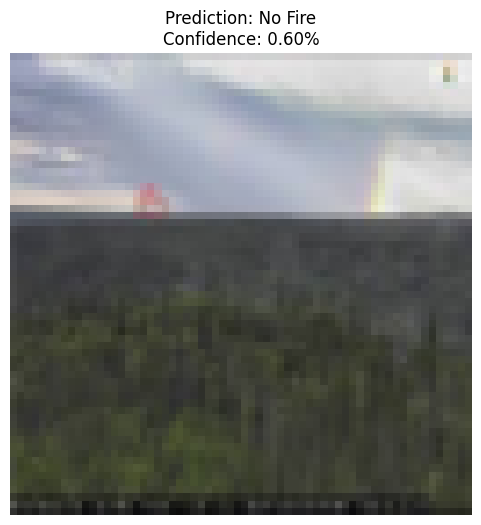

In [13]:
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT50vD84tvta1llHPiBZZkeTGmsG2vbXrbQug&s'
predict_single_image(image_url)

Making a prediction...


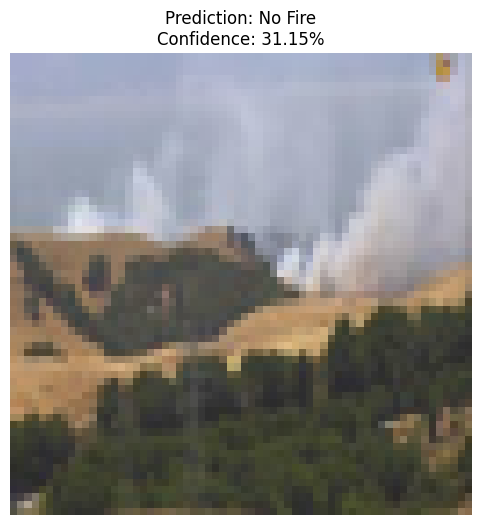

In [14]:
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjd6iJ2Rk66wk40uujE5t_B0KfbClGOpAPTA&s'
predict_single_image(image_url)

In [15]:
import time

# ... (rest of the code to load the model and data) ...

if X_new.size > 0:
    print("\nMeasuring inference time...")
    
    # Select one image from your new dataset for the test
    single_image = X_new[0:1].T
    
    # Run a few warmup predictions
    for _ in range(10):
        _ = loaded_mlp.forward(single_image)

    # Measure the average time over 100 predictions
    start_time = time.time()
    for _ in range(100):
        _ = loaded_mlp.forward(single_image)
    end_time = time.time()
    
    average_inference_time_ms = (end_time - start_time) / 100 * 1000
    
    print(f"Average inference time: {average_inference_time_ms:.2f} ms")
    
    # ... (rest of the evaluation code) ...


Measuring inference time...
Average inference time: 0.24 ms
